# COMP7015: Artificial Intelligence *(Semester 1, 2022/23)*

# Programming Assignment 2

**Instructions:**
1. Fill in your name and student id in the following cell.
2. Write all you codes in this jupyter notebook.
3. You can define your own functions, methods, classes, and variables as you need.
4. Please name your functions and variables in a clear and concise way to maximize the redability of your codes.
5. Name your jupyter notebook in the format of `pa2_<student id>.ipynb` and submit it in Moodle. For example, `pa2_16483715.ipynb`.
6. What you write in this notebook must be your own input. Copying from others and online resources are subject to heavy penalty. Lending and borrowing assignment solutions are both regarded as dishonest behaviours and are subject to heavy penalty and disciplinary actions.

In [ ]:
# Fill in your name and student ID
name = 'XU Haohang'
student_id = '22436804'

# Q1. Handwritten letter recognition with MLP (50 marks)

In this task, you are required to define and train an MLP model for the handwritten letter recognition task. We use the `EMNIST` dataset. See [[its Readme file]](https://www.westernsydney.edu.au/__data/assets/text_file/0019/1204408/EMNIST_Readme.txt) for a detailed description. We provide you with the following code block to load the dataset.

In this dataset, there are 124,800 images for training and 20,800 images for testing. Each image corresponds to one of the 26 English letters.

In [2]:
import torch
from torch import nn
import torchvision
from torchvision import transforms
from torchvision.datasets import EMNIST
from matplotlib import pyplot as plt

In [4]:
# Some transformation are needed.
emnist_transform = transforms.Compose([
    lambda img: transforms.functional.rotate(img, -90),  # rotates the image by 90 degree
    lambda img: transforms.functional.hflip(img),  # flip the image horizontally
    transforms.ToTensor()
])
# The dataset can be loaded using the Pytorch function as below
emnist_train = EMNIST('./', train=True, download=True, split='letters', 
                      transform=emnist_transform,
                      target_transform=lambda x: x-1)
emnist_test = EMNIST('./', train=False, download=True, split='letters', 
                     transform=emnist_transform,
                     target_transform=lambda x: x-1)

  0%|          | 0/561753746 [00:00<?, ?it/s]

Extracting ./EMNIST/raw/gzip.zip to ./EMNIST/raw


A visualization of the dataset can be done as follows. It gives you an intuition about the dataset we are working with.

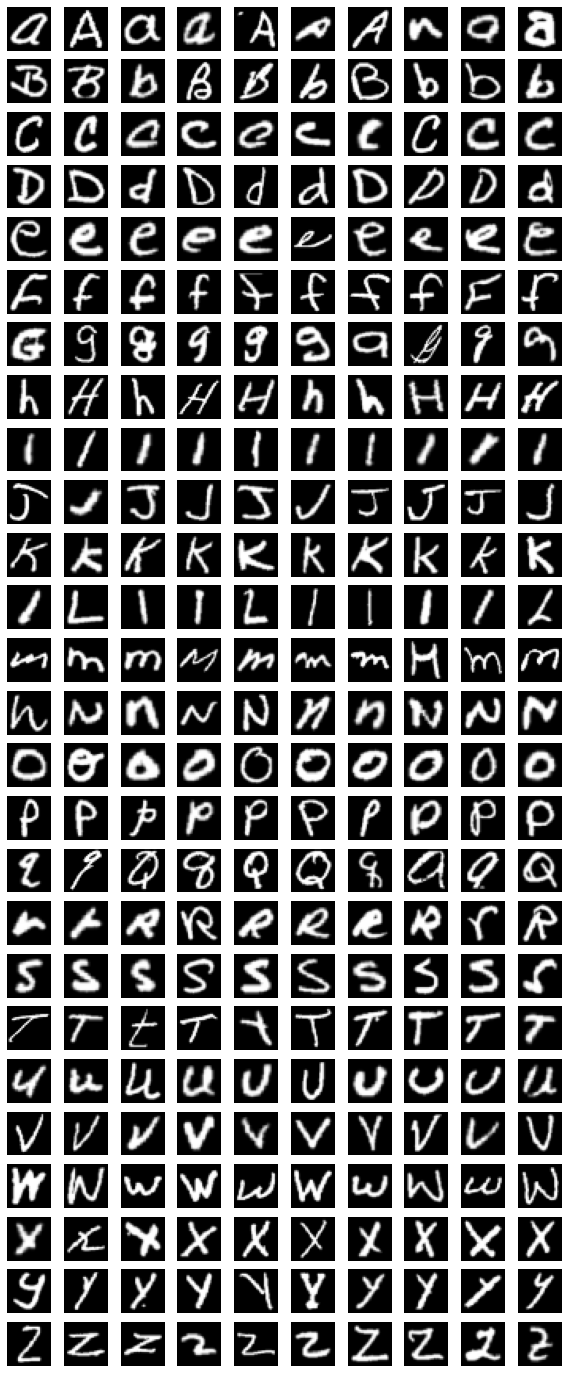

In [ ]:
_, labels = zip(*emnist_train)
indices = [[i for i in range(len(labels)) if labels[i]==c] for c in range(26)]

fig, ax = plt.subplots(26, 10, figsize=(10, 25))
for c in range(26):
    for i in range(10):
        ax[c][i].imshow(emnist_train[indices[c][i]][0][0].numpy(), cmap='gray')
        ax[c][i].axis('off')
plt.show()

## (a) Define an MLP model to recognize the handwritten letters. Use three hidden layers for this MLP and the hidden sizes of the three hidden layers are 256, 512, and 512, respectively. Use ReLU as the activation function. (15 marks)

In [ ]:
from torch import nn
# let's define a MLP model

class MLP(nn.Module):
    def __init__(self, input_dim, output_dim):
        super().__init__()
        self.layers = nn.Sequential(
            nn.Linear(input_dim,256),    
            nn.ReLU(),        # first  hidden layer
            nn.Linear(256,512),
            nn.ReLU(),        # second hidden layer
            nn.Linear(512,512),
            nn.ReLU(),        # third  hidden layer
            nn.Linear(512,output_dim),
            nn.Softmax(1)    # add softmax for multi-classificaiton
            )
    def forward(self, x):
        x = x.view(x.shape[0], -1)
        return self.layers(x) 

In [ ]:
mlp = MLP(28*28,26)

## (b) Train an MLP model to recognize the handwritten letters. The following aspects should be covered in your answers.
1. The full pipeline of training such a model. (15 marks)
2. Sample some data from the training set as validation set. Monitor the accuracy over validation set during training and do early stopping based on the validation accuracy. (10 marks)
2. Compute the accuracy for the test set. (10 marks)

In [ ]:
#split the training set into training and validation part, 
#and size(training set) : size(validation set) = 3:1
#then use SubsetRandomSampler to sample data training and validation 
import random
n_train = len(emnist_train)
split = n_train // 4
indices =list(range(n_train))
random.shuffle(indices)
train_sampler = torch.utils.data.sampler.SubsetRandomSampler(indices[split:])
valid_sampler = torch.utils.data.sampler.SubsetRandomSampler(indices[:split])
train_loader = torch.utils.data.DataLoader(emnist_train,batch_size=128,sampler=train_sampler)
valid_loader = torch.utils.data.DataLoader(emnist_train,batch_size=128,sampler=valid_sampler)


In [ ]:
optimizer = torch.optim.SGD(mlp.parameters(),
                            lr=0.3,
                            weight_decay=0.0002,  
                            momentum=0.9)
loss = torch.nn.CrossEntropyLoss()


In [ ]:
import time
mlp.train() 
since = time.time()
def training():
    train_iter = 0
    val_iter = 0
    for iter in range(10):
        tic = time.time()
        for data in enumerate(train_loader):
            train_iter+=1
            image, label = data[1]
            image = image
            label = label 
            optimizer.zero_grad()  
            output = mlp(image)  
            new_loss = loss(output, label)  
            new_loss.backward() 
            optimizer.step()  
        with torch.no_grad():
            
            for vld_data in enumerate(valid_loader): 
                val_iter += 1
                img, lbl = vld_data[1] 
                output = mlp(img) 
                res_lbl = output.argmax(dim=1)
                correct_samples = (res_lbl == lbl).sum()
                acc = correct_samples / lbl.shape[0]
                if val_iter % 100 == 0:
                    print(f"validation Iteration: {val_iter}, Accuracy: {acc:.3f}")
                    #early stopping 
                    if acc>=0.9:
                        return acc 
        print(f'num of epch {iter}')
        print('Time: {:.1f}s'.format(time.time()-tic))
    time_elapsed = time.time() - since
    print('trainig and validation complete in {:.0f}m {:.0f}s'.format(time_elapsed // 60, time_elapsed % 60))    
    return acc
training()

validation Iteration: 100, Accuracy: 0.695
validation Iteration: 200, Accuracy: 0.664
num of epch 0
Time: 14.9s
validation Iteration: 300, Accuracy: 0.672
validation Iteration: 400, Accuracy: 0.664
num of epch 1
Time: 15.2s
validation Iteration: 500, Accuracy: 0.711
validation Iteration: 600, Accuracy: 0.727
validation Iteration: 700, Accuracy: 0.664
num of epch 2
Time: 15.5s
validation Iteration: 800, Accuracy: 0.711
validation Iteration: 900, Accuracy: 0.672
num of epch 3
Time: 15.8s
validation Iteration: 1000, Accuracy: 0.648
validation Iteration: 1100, Accuracy: 0.664
validation Iteration: 1200, Accuracy: 0.664
num of epch 4
Time: 15.8s
validation Iteration: 1300, Accuracy: 0.719
validation Iteration: 1400, Accuracy: 0.672
num of epch 5
Time: 16.0s
validation Iteration: 1500, Accuracy: 0.719
validation Iteration: 1600, Accuracy: 0.781
validation Iteration: 1700, Accuracy: 0.727
num of epch 6
Time: 16.0s
validation Iteration: 1800, Accuracy: 0.672
validation Iteration: 1900, Accurac

tensor(0.7812)

In [ ]:
#test process
def testing():
    mlp.eval() 
    correct = 0
    total = 0
    test_loader = torch.utils.data.DataLoader(emnist_test,batch_size=128)
    with torch.no_grad():
        for data in enumerate(test_loader):
            image, label = data[1]
            output = mlp(image) 
            res_lbl = output.argmax(dim=1)
            correct += (res_lbl == label).sum()
            total += label.shape[0]
        acc = correct / total

    print(f"Accuracy for testing dataset: {acc:.3f}")
testing()

Accuracy for testing dataset: 0.712


# Q2. Basics of Convolutional Neural Network (30 marks)

## (a) Complete the function below to compute the convolution given an `input_tensor` (a two-dimensional tensor), a `kernel_tensor` and a `stride_size`. For simplicity, we only consider gray scale images. The function should return the output after doing convolution. The followings are expected. (20 marks)
1. The function correctly computes the convolution. (10 marks)
2. The function correctly handles different stride sizes. (5 marks)
3. The function output has the the same size as the input by using padding. (5 marks) 

**Hint**: the padding size can be computed using the equation given in lectures that computes the output size of the convolution.

In [ ]:
import torch.nn.functional as F
def convolution(input_tensor, kernel_tensor, stride_size):
    # fill in your codes
    convs = torch.tensor([])
    for j in range(kernel_tensor.shape[0],input_tensor.shape[0]+1,stride_size): 
        temp = torch.tensor([])
        for i in range(kernel_tensor.shape[1],input_tensor.shape[1]+1,stride_size):
            conv =input_tensor[j-kernel_tensor.shape[0]:j,i-kernel_tensor.shape[1]:i]*kernel_tensor
            sumamtion = torch.tensor([[conv.sum()]])
            temp = torch.cat((temp,sumamtion))
        convs = torch.cat((convs,temp),1)
    ph = int(((input_tensor.shape[0]-1)*stride_size+kernel_tensor.shape[0]-input_tensor.shape[0])/2)
    pv = int(((input_tensor.shape[1]-1)*stride_size+kernel_tensor.shape[1]-input_tensor.shape[1])/2)
    #if the padding size is not symmatric 
    phl=ph
    pvt = pv
    if convs.shape[0]+ph*2>input_tensor.shape[0]:
        phl = ph -1
    elif convs.shape[0]+ph*2<input_tensor.shape[0]:
        phl = ph +1       
    if convs.shape[1]+pv*2>input_tensor.shape[1]:
        pvt = pv-1
    elif convs.shape[1]+pv*2<input_tensor.shape[1]:
        pvt = pv +1    
    F.pad(convs,[ph,phl,pv,pvt])
    output =F.pad(convs,[ph,ph,pv,pvt])
    return output

##### The following code blocks are examples of calling this function. Do NOT modify them.

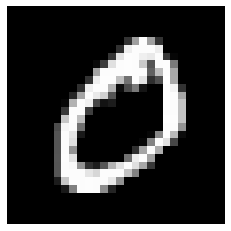

In [ ]:
# load in an image
img = torch.load('./img.pt')
plt.imshow(img.numpy(), cmap='gray')
plt.axis('off')

# define a kernel
kernel = torch.FloatTensor([
    [-1, -1, -1],
    [1, 1, 1],
    [0, 0, 0]
])


(-0.5, 27.5, 27.5, -0.5)

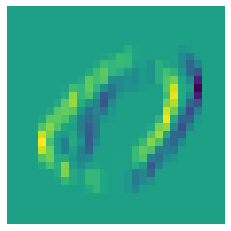

In [ ]:
# An example of calling your function
output = convolution(img, kernel, stride_size=1)

# Your output should be visualized if your function is working as desired.
plt.imshow(output.numpy())
plt.axis('off')

(-0.5, 40.5, 39.5, -0.5)

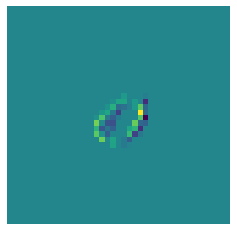

In [ ]:
# Another example
output = convolution(img, kernel, stride_size=2)

# Your output should be visualized if your function is working as desired.
plt.imshow(output.numpy())
plt.axis('off')

## (b) Complete the function below to do the max pooling given `input tensor` (a two-dimensional tensor), a `kernel_size` and a `stride_size`.  (10 marks)

In [ ]:
def max_pooling(input_tensor, kernel_size, stride_size):
    # fill in your codes
    pooling = torch.tensor([])
    for j in range(kernel_size,input_tensor.shape[0]+1,stride_size): 
        temp = torch.tensor([])
        for i in range(kernel_size,input_tensor.shape[1]+1,stride_size):
            conv =input_tensor[j-kernel_size:j,i-kernel_size:i]
            maximum =torch.tensor([[torch.max(conv)]])
            temp = torch.cat((temp,maximum),1)
        pooling = torch.cat((pooling,temp))
    output = pooling
    return output

##### The following code block is an example of calling this function. Do NOT modify it.

(-0.5, 13.5, 13.5, -0.5)

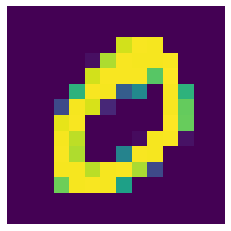

In [ ]:
output_pooling = max_pooling(img, kernel_size=2, stride_size=2)

plt.imshow(output_pooling.numpy())
plt.axis('off')

# Q3. Using Pretrained CV Models (20 marks)

In this question, we use a pretrained CV model and fine-tune it for a classification task. We use the ResNet model. Here is a detailed insruction about how to use it: https://pytorch.org/hub/pytorch_vision_resnet/.

The `torch.hub` module is a newer way to import and use pretrained models. The procedures of fine-tune it are the same as introduced in the lab session.

In [6]:
# The pretrained model can be loaded by the following line and the corresponding data transform is given.

import torchvision.models as models
from torchvision.models.resnet import  model_urls
#model = torch.hub.load_state_dict_from_url(model_urls['resnet18'],pretrained = True)
model = torch.hub.load('pytorch/vision:v0.10.0', 'resnet18', pretrained=True)

resnet_transform = transforms.Compose([
    transforms.Grayscale(3),
    transforms.Resize(256),
    transforms.CenterCrop(224),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])



Using cache found in /Users/xhh/.cache/torch/hub/pytorch_vision_v0.10.0


In [7]:
# this shows you the architecture of the ResNet model.
model

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

**Hint**: As shown above, the last layer for classification in ResNet18 model is called `fc`.

## (a) Fine-tune the ResNet model for the handwritten letter recognition dataset (EMNIST) we used in Q1.  The followings are expected. (15 marks)

1. Build the full pipeline of fine-tuning the pretrained ResNet model. (5 marks)
2. Sample some data from the training set as validation set. Monitor the accuracy over validation set during training and do early stopping based on the validation accuracy. (5 marks)
2. Compute the accuracy for the test set. (5 marks)

In [6]:
from torch.optim import Adam
for param in model.parameters():
    param.requires_grad = False
ft_num = model.fc.in_features
model.fc = nn.Linear(ft_num, 26)
params_to_update = []
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
model = model.to(device)
print(device)
print("Params to learn:")
for name, param in model.named_parameters():
    if param.requires_grad == True:
        params_to_update.append(param)
        print("\t",name)

optimizer_ft = Adam(params_to_update, lr=0.0001)
criterion = nn.CrossEntropyLoss()

cuda:0
Params to learn:
	 fc.weight
	 fc.bias


In [7]:
import random
emres_train = EMNIST('./', train=True, download=True, split='letters', 
                      transform=resnet_transform)
emres_test = EMNIST('./', train=False, download=True, split='letters', 
                     transform=resnet_transform)
emres_train.targets = emres_train.targets.add(-1)
emres_test.targets  = emres_test.targets.add(-1)
nums_train = len(emres_train)
split = nums_train // 4
indices =list(range(nums_train))
random.shuffle(indices)
restrain_sampler = torch.utils.data.sampler.SubsetRandomSampler(indices[split:])
resvalid_sampler = torch.utils.data.sampler.SubsetRandomSampler(indices[:split])
restrain_loader = torch.utils.data.DataLoader(emres_train,batch_size=128,sampler=restrain_sampler)
resvalid_loader = torch.utils.data.DataLoader(emres_train,batch_size=128,sampler=resvalid_sampler)
restest_loader = torch.utils.data.DataLoader(emres_train,batch_size=128)

In [ ]:
model #see the fine-modified model

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

In [8]:
#training process
import time
from copy import deepcopy
num_epochs = 10
since = time.time()
val_acc_history = []
best_acc = 0.0
best_model_wts = deepcopy(model.state_dict)
for epoch in range(num_epochs):
    tic = time.time()
    print('Epoch {}/{}'.format(epoch+1, num_epochs))
    print('-' * 15)

    model.train() 
    loss_iter = 0
    corr_iter = 0

    for inputs, labels in restrain_loader:
        inputs = inputs.cuda()
        labels = labels.cuda()
        optimizer_ft.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs,labels)
        loss.backward()
        optimizer_ft.step()
        _, preds = torch.max(outputs, 1)
        loss_iter += loss.item() * inputs.size(0)
        corr_iter += torch.sum(preds == labels.data)
        ep_loss = loss_iter / len(restrain_loader.dataset)
    ep_acc = corr_iter.double() / len(restrain_loader.dataset)
    print('Training Loss: {:.4f} Acc: {:.4f}'.format(ep_loss, ep_acc))
    
    #validation process
    model.eval()   
    loss_iter = 0.0
    corr_iter = 0
    with torch.no_grad():
        for inputs, labels in resvalid_loader:
            inputs = inputs.cuda()
            labels = labels.cuda()
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            _, preds = torch.max(outputs, 1)
            loss_iter += loss.item() * inputs.size(0)
            corr_iter += torch.sum(preds == labels.data)
    ep_loss = loss_iter / len(resvalid_loader.dataset)
    ep_acc = corr_iter.double() / len(resvalid_loader.dataset)
    print('Validation Loss: {:.4f} Acc: {:.4f}'.format(ep_loss, ep_acc))

    if ep_acc > best_acc:
        best_acc = ep_acc
        best_model_wts = deepcopy(model.state_dict())
    val_acc_history.append(ep_acc)
    print('Time: {:.1f}s'.format(time.time()-tic))
    print('='*15)
    print()

time_elapsed = time.time() - since
print('Finetuning complete in {:.0f}m {:.0f}s'.format(time_elapsed // 60, time_elapsed % 60))
print('Best validation Acccuracy: {:4f}'.format(best_acc))
model.load_state_dict(best_model_wts)

Epoch 1/10
---------------
Training Loss: 1.7733 Acc: 0.3287
Validation Loss: 0.4382 Acc: 0.1543
Time: 354.5s

Epoch 2/10
---------------
Training Loss: 1.1316 Acc: 0.4965
Validation Loss: 0.3286 Acc: 0.1717
Time: 350.9s

Epoch 3/10
---------------
Training Loss: 0.9086 Acc: 0.5329
Validation Loss: 0.2789 Acc: 0.1808
Time: 356.8s

Epoch 4/10
---------------
Training Loss: 0.7905 Acc: 0.5529
Validation Loss: 0.2490 Acc: 0.1857
Time: 357.2s

Epoch 5/10
---------------
Training Loss: 0.7172 Acc: 0.5645
Validation Loss: 0.2301 Acc: 0.1893
Time: 354.6s

Epoch 6/10
---------------
Training Loss: 0.6648 Acc: 0.5741
Validation Loss: 0.2151 Acc: 0.1915
Time: 350.3s

Epoch 7/10
---------------
Training Loss: 0.6262 Acc: 0.5816
Validation Loss: 0.2041 Acc: 0.1935
Time: 350.4s

Epoch 8/10
---------------
Training Loss: 0.5953 Acc: 0.5870
Validation Loss: 0.1946 Acc: 0.1956
Time: 349.3s

Epoch 9/10
---------------
Training Loss: 0.5713 Acc: 0.5924
Validation Loss: 0.1877 Acc: 0.1971
Time: 350.0s

E

<All keys matched successfully>

In [2]:
#testing process 
model.eval()
running_loss = 0.0
running_corrects = 0
with torch.no_grad():
    for inputs, labels in restest_loader:
        inputs = inputs.to(device)
        labels = labels.to(device)
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        _, preds = torch.max(outputs, 1)
        running_loss += loss.item() * inputs.size(0)
        running_corrects += torch.sum(preds == labels.data)
epoch_loss = running_loss / len(resvalid_loader.dataset)
epoch_acc = running_corrects.double() / len(resvalid_loader.dataset)
print('Testing Loss: {:.4f} Acc: {:.4f}'.format(epoch_loss, epoch_acc))


Testing Loss: 0.6912 Acc: 0.6853


## (b) Summarize the differences between the performance you obtain using the MLP and that obtained by the fine-tuned model. (5 marks)

  **Generally speaking, our MLP model has a better performance**

1. Training Time

* It is obvious that using fine-tuned model takes more time. I guess it is because that it has more complex structure and computing process takes much time. By contrast, our of MLP structure is relatively simple, and the number of parameters is smaller. So the training process is faster.

2. Accuracy
* fine-tuned model have a lower accuracy than our MLP model. And also fine-tuned model seems to be overfitting, because it has much higher accuracy in training dataset than in validation dataset 





